In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(precision=4, suppress=True)

## Load data and trained model

In [3]:
# data generated by make_data script
with np.load('nn-inverse-data.npz') as data:
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
    A = data['A']
    
# models trained in train_*_network scripts
linear_output_model = tf.keras.models.load_model('nn-linear-output')
fully_sigmoid_model = tf.keras.models.load_model('nn-fully-sigmoid')

## Visual comparison of original and reconstructed images

Both models give good reconstruction of all types of images. The fully sigmoid model outputs vectors with range in (0,1), but at the expense at not being able to capture the contrast of the images as well. The linear output model does better at the contrast, but the output often lies a bit outside (0,1). I didn't originally realize that the final layer had a linear activation, as all the regression network examples seemed to do it (in retrospect, for the obvious reason of not having a bounded range), but I think now that those last 5000x100 weights with a linear activation allowed the training to converge to the pseudo-inverse, in the same way that the fully linear network we tried was able to do. Possible next steps:
1. Analyze the weights of the mostly-sigmoid linear output model. See if the training converged to a solution that basically ignores the sigmoid neurons and somehow contains the pseudo-inverse in the last layer?
2. Try a fully ReLU network, which wouldn't have the contrast problem. Previously we were looking at a ReLU network with a linear output layer and it didn't have $J\rightarrow A^+$ during the training, but making it all ReLU might give something interesting.

In [4]:
def plot_img_comparison(mat0, mat1, scale_to_01=False, left_title='', right_title=''):
    '''
    Plot two matrices as images, side-by-side.
    
    If scale_to_01=False, (min(both images), max(both images)) -> (black, white)
    If scale_to_01=True, (0,1) -> (black, white)
    '''
    fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)
    axs[0].set_title(left_title)
    axs[1].set_title(right_title)
    
    # if the domain of the images is within [0,1], then 0 -> black, 1 -> white
    if scale_to_01:
        im0 = axs[0].imshow(mat0, cmap='gray', vmin=0, vmax=1)
        im1 = axs[1].imshow(mat1, cmap='gray', vmin=0, vmax=1)

        # set colorbar in-between images
        fig.colorbar(im0, ax=axs[0])

    # shared scale of overall_min -> black, overall_max -> white
    else:
        overall_min = np.min([np.min(mat0),np.min(mat1)])
        overall_max = np.max([np.max(mat0),np.max(mat1)])
        
        im0 = axs[0].imshow(mat0, cmap='gray', vmin=overall_min, vmax=overall_max)
        im1 = axs[1].imshow(mat1, cmap='gray', vmin=overall_min, vmax=overall_max)

        fig.colorbar(im0, ax=axs[0])
    plt.show()

### Using test/validation data:

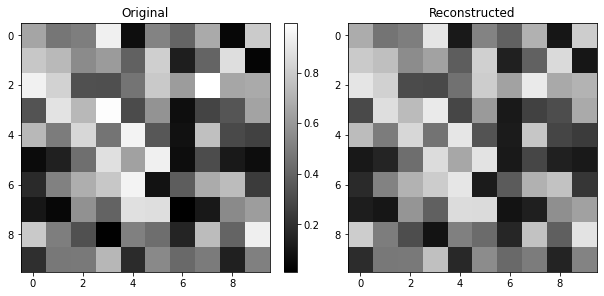

In [6]:
# grab vector in the original test data y_test
# and corresponding vector in encoded data x_test
idx = 0 # vary this to look at diff images
model = fully_sigmoid_model # switch to look at other model

orig_img = np.reshape(y_train[idx], (10,10))
nn_output = model(x_train[idx:idx+1])
recon_img = np.reshape(nn_output, (10,10))

plot_img_comparison(orig_img, recon_img,
                    left_title='Original', right_title='Reconstructed')

### Using cropped Numerical MNIST data

In [7]:
# load numerical images
with np.load('numerical-MNIST-data.npz') as data:
    number_imgs = data['test_imgs']

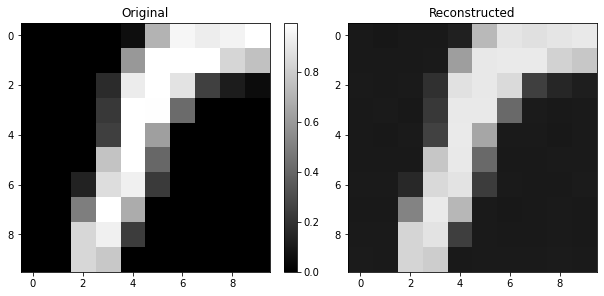

In [13]:
idx = 10 # vary this to look at diff images
model = fully_sigmoid_model # switch to look at other model

# crop a 10x10 section of this image with
# first row i and first column j
i = 5; j = 5
orig_img = number_imgs[idx:idx+1, i:i+10, j:j+10]

# flatten, encode with A, then run through network
x_in = np.reshape(orig_img, (1, 100)) @ A
nn_output = model(x_in)

# reshape network output to plot
recon_img = np.reshape(nn_output, (10,10))

# plot original and reconstructed images side-by-side
plot_img_comparison(orig_img[0], recon_img,
                    left_title='Original', right_title='Reconstructed')

### Using cropped Fashion MNIST data

In [14]:
# load fashion images
with np.load('fashion-MNIST-data.npz') as data:
    fashion_imgs = data['test_imgs']

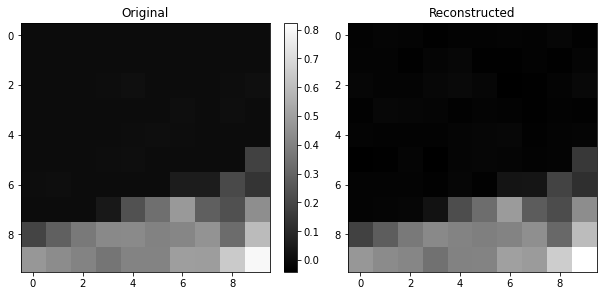

In [17]:
idx = 70 # vary this to look at diff images
model = linear_output_model # switch to look at other model

# crop a 10x10 section of this image with
# first row i and first column j
i = 5; j = 5
orig_img = fashion_imgs[idx:idx+1, i:i+10, j:j+10]

# flatten, encode with A, then run through network
x_in = np.reshape(orig_img, (1, 100)) @ A
nn_output = model(x_in)

# reshape network output to plot
recon_img = np.reshape(nn_output, (10,10))

# plot original and reconstructed images side-by-side
plot_img_comparison(orig_img[0], recon_img,
                    left_title='Original', right_title='Reconstructed')

## Comparison of Jacobian $J$ and pseudo-inverse $A^+$

In [18]:
def mean_abs_norm(A):
    return np.mean(np.abs(A))

def rms_norm(A):
    return np.mean(A**2)**0.5

def op_norm(A):
    return np.max(np.linalg.svd(A, compute_uv=False))

In [19]:
@tf.function
def batchJ(x, model):
    # x is a tf.Variable with N vectors of length n
    with tf.GradientTape() as tape:
        y = model(x)
    # if each output vector in y has length d then each
    # batch of Jacobians has shape N x d x n
    return tape.batch_jacobian(y, x)

In [20]:
@tf.function
def batch_JJt_diag(x,model):
    # x is a tf.Variable with N vectors of length n
    with tf.GradientTape() as tape:
        y = model(x)
    # if each output vector in y has length d then each
    # batch of Jacobians has shape N x d x n
    jacobians = tape.batch_jacobian(y, x)
    # the diagonal of JJt can be obtained via summing along
    # the third axis (size n) of the elementwise square
    # of the Jacobian. The batch of JJt diagonals will 
    # be size N x d 
    return tf.reduce_sum(jacobians**2, axis=2)

In [21]:
# (right) pseudo-inverse of 100x500 encoding matrix A
Ap = np.linalg.pinv(A) # 500x100

# fisher information with forward model A
# turns out that this is equal to Ap.T @ Ap too
fisher_info = A @ A.T # 100x100

In [27]:
idx = 0
x_in = x_test[idx:idx+10]
model = linear_output_model

Js = batchJ(tf.Variable(x_in), model)[0].numpy().T


[[ 0.0012 -0.0001  0.0001 ...  0.0004 -0.0004  0.0001]
 [ 0.0004  0.0017 -0.0002 ...  0.0003 -0.0004 -0.0006]
 [-0.0003  0.0006 -0.0004 ...  0.0003 -0.     -0.0005]
 ...
 [ 0.0002  0.0001 -0.0004 ... -0.001   0.001  -0.0006]
 [ 0.0007 -0.0006 -0.001  ...  0.0001  0.0002  0.0002]
 [ 0.0006  0.0006  0.0001 ... -0.0002 -0.0005 -0.0003]]


### Visual comparison of diagonals of $JJ^T$ and inverse Fisher information $I^{-1}$

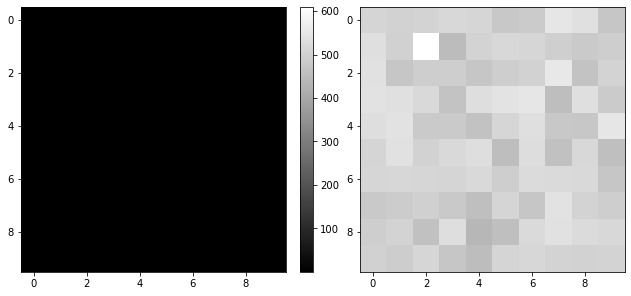

In [49]:
# evaluate the jacobian at a vector in the test data
idx = 0
x_in = x_train[idx:idx+1]
JJt_diag = batch_JJt_diag(tf.Variable(x_in), model) # 1x100

# plot as images
JJt_diag_img = np.reshape(JJt_diag, (10,10))
fisher_info_diag_img = np.reshape(np.diag(fisher_info), (10,10))
plot_img_comparison(JJt_diag_img, fisher_info_diag_img)

## Monte Carlo noise simulations
The hierarchy of similarity between the pseudo-CRLB and sample variance:
1. Visually similar & small norm
2. Positive correlation over one image 
3. Positive correlation over corresponding pixels in many images

In [44]:
def monte_carlo_noise_sim(y_orig, A, model, noise_lvl, N):
    '''
    Run a Monte Carlo simulation on a neural network.
    
    Encodes y_orig with matrix A, adds N realizations of WGN to
    encoded vector (i.e. in k-space) with variance = noise_lvl * max(y_orig @ A), 
    and then runs through NN inverse model.
    
    Returns dict with fields:
        sigma: standard deviation of WGN added in k-space (1x1)
        y_clean_recon: NN output of clean encoded y_orig (1x100)
        ys_noisy_recon: NN outputs of encoded y_orig + noise (Nx100)
        y_noisy_mean: mean(ys_noisy_recon) (1x100)
        bias: y_noisy_mean - y_orig (1x100)
        variance: sample variance of ys_noisy_recon (1x100)
        pseudo_crlb: sigma^2 * J @ J.T evaluated at y_orig @ A (100x500)
    '''
    # y (1x100) -- A --> x (1x500)
    #          <-- NN --        
    x_clean = np.reshape(y_orig @ A, (1,500)) # Tensorflow needs 2D input
    
    # define variance of noise to be fraction of maximum of encoded vector
    sigma = np.sqrt(noise_lvl*np.max(x_clean))

    # add N realizations of WGN
    noise_realizations = sigma*np.random.randn(N, 500)
    xs_noisy = x_clean + noise_realizations # broadcasted

    # feed through network to reconstruct. Note that imperfect reconstruction
    # implies that y_orig =/= y_clean_recon
    y_clean_recon = model(x_clean) # 1 X 100
    ys_noisy_recon = model(xs_noisy) # N x 100
    
    # take average to get best estimate of y_orig based on ys_noisy_recon
    # Note that nonlinear reconstruction implies that
    # E[y_noisy_estimate] =/= y_clean_recon
    y_noisy_mean = np.mean(ys_noisy_recon, axis=0)
    
    # sample bias and sample variance
    bias = y_noisy_mean - y_orig 
    variance = 1/(N-1) * np.sum((ys_noisy_recon - y_noisy_mean)**2, axis=0)
    
    # get jacobian and reshape from 1x100x500 -> 100x500
    jacobian = np.reshape(batchJ(tf.Variable(x_clean), model), (100,500))
    pseudo_crlb = sigma**2 * jacobian @ jacobian.T
    
    # compile results
    results = {'sigma': sigma,
               'y_clean_recon': y_clean_recon,
               'ys_noisy_recon': ys_noisy_recon,
               'y_noisy_mean': y_noisy_mean,
               'bias': bias,
               'variance': variance,
               'pseudo_crlb': pseudo_crlb}
    return results

### Comparison of pseudo-CRLB and pixel-wise sample variance

In [38]:
idx = 100
y_orig = y_test[idx]
results = monte_carlo_noise_sim(y_orig, A, model, noise_lvl=0.5, N=2000)

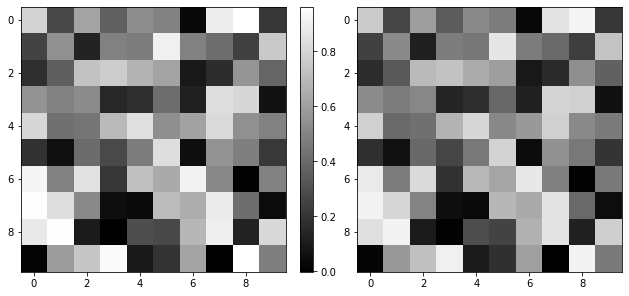

In [39]:
orig_img = np.reshape(y_orig, (10,10))
mean_noisy_img = np.reshape(results['y_noisy_mean'], (10,10))

plot_img_comparison(orig_img, mean_noisy_img)

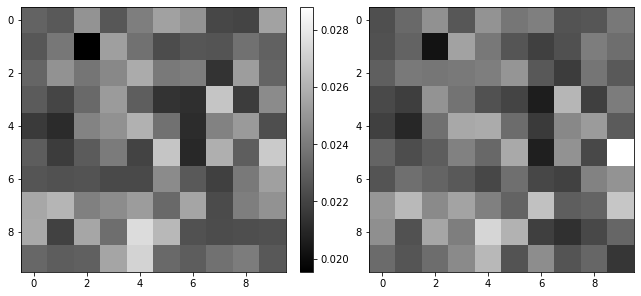

In [43]:
var_img = np.reshape(results['variance'], (10,10))
pseudo_crlb_diag = np.diag(results['pseudo_crlb'])

pseudo_crlb_diag_img = np.reshape(pseudo_crlb_diag, (10,10))

plot_img_comparison(results['sigma']**2 * ApApt_diag_img, var_img)

In [41]:
results['variance'] - crlb_diag

array([-0.0025, -0.0015, -0.0021, -0.0021, -0.0012, -0.0032, -0.0028,
       -0.0012, -0.0011, -0.0037, -0.0023, -0.0028, -0.0012, -0.0018,
       -0.0014, -0.0012, -0.0026, -0.0021, -0.0015, -0.0014, -0.002 ,
       -0.0029, -0.002 , -0.0025, -0.0033, -0.001 , -0.0033, -0.0017,
       -0.0032, -0.0025, -0.0027, -0.0023, -0.0005, -0.0035, -0.0026,
       -0.0014, -0.0024, -0.0022, -0.0017, -0.0025, -0.0018, -0.0019,
       -0.0027, -0.0013, -0.0022, -0.0024, -0.0013, -0.0015, -0.0021,
       -0.0016, -0.0016, -0.0016, -0.0021, -0.0018, -0.0006, -0.0032,
       -0.0022, -0.0031, -0.0024, -0.0002, -0.002 , -0.0011, -0.0011,
       -0.0014, -0.0019, -0.0032, -0.0023, -0.0017, -0.002 , -0.0025,
       -0.0023, -0.0018, -0.0016, -0.0011, -0.003 , -0.002 , -0.0011,
       -0.001 , -0.0029, -0.0001, -0.0025, -0.0011, -0.002 , -0.0014,
       -0.0023, -0.0025, -0.0025, -0.003 , -0.0022, -0.0011, -0.0018,
       -0.002 , -0.0014, -0.0029, -0.003 , -0.0026, -0.0004, -0.0031,
       -0.0026, -0.0

### Correlation between pseudo-CRLB and pixel-wise sample variance over different input vectors

Define shifted samples $\hat{x_i} = x_i - \mu_x$ and $\hat{y_i} = y_i - \mu_y$ where $\mu_x$
and $\mu_y$ are the means of $x_i$ and $y_i$ respectively. Then
$$ \rho = \frac{\sum_i \hat{x_i} \hat{y_i}}{\sqrt{(\sum_i \hat{x_i}^2) (\sum_i \hat{y_i}^2)}} $$

In [22]:
def correlation(x, y):
    '''Calculate correlation coefficient between two vectors.'''
    centered_x = x - np.mean(x)
    centered_y = y - np.mean(y)
    # perturb denominator by a small epsilon so that a constant series
    # gets a correlation of 0
    # (don't really remember when we were thinking this would be useful/necessary)
    eps = 1e-10
    return np.sum(centered_x * centered_y) \
            / (np.sqrt(np.sum(centered_x**2) * np.sum(centered_y**2)) + eps)

In [23]:
def uncentered_correlation(x, y):
    '''Calculate "uncentered" correlation coefficient, <x,y>/(||x||*||y||)'''
    # perturb denominator by a small epsilon so that a constant series
    # gets a correlation of 0
    # (don't really remember when we were thinking this would be useful/necessary)
    eps = 1e-10
    return np.sum(x*y) / (np.sqrt(np.sum(x**2) * np.sum(y**2)) + eps)

In [25]:
def pixel_correlation(A, B, use_uncentered=False):
    '''
    Calculate correlation coefficients between columns of two matrices.
    
    Each row of A and B is a flattened image, so each column gives how
    a single pixel changes from image to image. 
    
    Arguments:
        A: N row-vectors of length d (Nxd)
        B: ditto
        use_uncentered: set to True if the uncentered correlation is
            desired. Defaults to False.
    '''
    d = A.shape[1] # number of columns, corresponds to image size
    corr_coefs = np.zeros(d)
    for col in range(A.shape[1]):
        if use_uncentered:
            corr_coefs = uncentered_correlation(A[:,col], B[:,col])
        else:
            corr_coefs = correlation(A[:,col], B[:,col])
        
    return corr_coefs

First need to find a good value of N for the Monte Carlo noise simulations...should experiment above